In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

sys.path.append(str(Path("..").resolve()))
from src.visualizations import setup_tueplots, plot_wind_power_composition
from src.preprocessing import Column, preprocess_supply_data


In [1]:
path = Path('..') / 'data' / 'Realised_Supply_Germany.csv'
df = pd.read_csv(path, sep=';', decimal=',')

NameError: name 'Path' is not defined

In [3]:
df = preprocess_supply_data(df, resample="h")

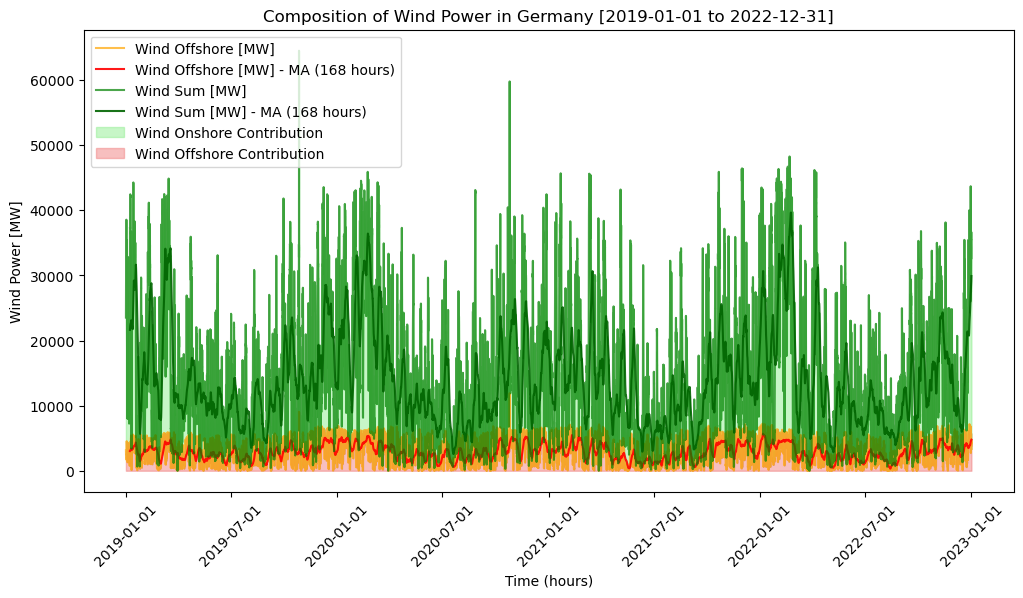

In [4]:
fig = plot_wind_power_composition(
    dates=df.index,
    wind_offshore=df[Column.WIND_OFFSHORE.value],
    wind_onshore=df[Column.WIND_ONSHORE.value],
    moving_average_window=24*7
)

In [5]:
# Train test split
target = [Column.WIND.value]
df = df[target].copy()

# Split the data into training and test sets
split_date = "2022-01-01"
start_date = df.index[0]
end_date = df.index[-1]
train_data = df["2021-01-01":split_date]
test_data = df[split_date:end_date]
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8784 entries, 2021-01-01 00:00:00 to 2022-01-01 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Wind Sum [MW]  8784 non-null   float64
dtypes: float64(1)
memory usage: 137.2 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2022-01-01 00:00:00 to 2022-12-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Wind Sum [MW]  8760 non-null   float64
dtypes: float64(1)
memory usage: 136.9 KB


In [6]:
def create_time_features(df: pd.DataFrame):
    """
    Create time-based features from the datetime index of the dataframe.
    
    Args:
        df: DataFrame with DatetimeIndex
        
    Returns:
        DataFrame with time features added
    """
    df_with_features = df.copy()
    
    # Add cyclical time features using sine and cosine transformations
    # Hour of day (24 hours)
    df_with_features['hour_sin'] = np.sin(2 * np.pi * df.index.hour / 24)
    df_with_features['hour_cos'] = np.cos(2 * np.pi * df.index.hour / 24)
    
    # Day of week (7 days)
    df_with_features['dayofweek_sin'] = np.sin(2 * np.pi * df.index.dayofweek / 7)
    df_with_features['dayofweek_cos'] = np.cos(2 * np.pi * df.index.dayofweek / 7)
    
    # Month of year (12 months)
    df_with_features['month_sin'] = np.sin(2 * np.pi * df.index.month / 12)
    df_with_features['month_cos'] = np.cos(2 * np.pi * df.index.month / 12)
    
    # Day of year (365 days)
    df_with_features['dayofyear_sin'] = np.sin(2 * np.pi * df.index.dayofyear / 365.25)
    df_with_features['dayofyear_cos'] = np.cos(2 * np.pi * df.index.dayofyear / 365.25)
    
    return df_with_features

# Create a function to generate the training and test sets
def create_sliding_window_data(data: pd.DataFrame, history: int, forecast_horizon: int):
    """
    Create sliding window data for time series forecasting.
    
    Args:
        data: DataFrame with time series data
        history: Number of past time steps to use as input
        forecast_horizon: Number of future time steps to predict
    Returns:
        X: Input data - features of shape (samples, history, features)
        y: Target data - labels of shape (samples, forecast_horizon)
    """
    X, y = [], []
    for i in range(len(data) - history - forecast_horizon + 1):
        history_data = data.iloc[i : i + history].values
        future_data = data.iloc[i + history : i + history + forecast_horizon][
            Column.WIND.value
        ].values
        X.append(history_data)
        y.append(future_data)
    return np.array(X), np.array(y)



In [8]:
# Sliding window training
history = 24  # 168 hours = 7 days (lag features)
horizon = 4  # 24 hours

# train = create_time_features(train_data.copy())
# test = create_time_features(test_data.copy())
train = train_data.copy()
test = test_data.copy()

X, y = create_sliding_window_data(train, history=history, forecast_horizon=horizon)
X_test, y_test = create_sliding_window_data(
    test, history=history, forecast_horizon=horizon
)
X.shape, y.shape, X_test.shape, y_test.shape

((8757, 24, 1), (8757, 4), (8733, 24, 1), (8733, 4))

In [9]:
float_precision = np.float32
# Flatten lag and feature dimensions
X = X.reshape(X.shape[0], -1).astype(float_precision)
X_test = X_test.reshape(X_test.shape[0], -1).astype(float_precision)
y, y_test = y.astype(float_precision), y_test.astype(float_precision)

In [10]:
# Kernel: RBF * Constant
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

In [11]:
gp_models = []
y_preds = []
y_sigmas = []

print("Training Gaussian Process...")
for h in range(horizon):
    print(f"Training Gaussian Process for hour {h + 1}/{horizon}...")
    
    y_h = y[:, h]
    
    # Create the Gaussian Process model
    gp_h = GaussianProcessRegressor(
        kernel=kernel, 
        alpha=1e-2,
        normalize_y=True,
        n_restarts_optimizer=2,
        random_state=42
    )

    # Fit the model to the training data
    gp_h.fit(X, y_h)
    gp_models.append(gp_h)

    y_pred, y_sigma = gp_h.predict(X_test, return_std=True)

    y_preds.append(y_pred)
    y_sigmas.append(y_sigma)
    print(f"Finished training for hour {h + 1}/{horizon}.")
    print(f"Predicted mean: {y_pred.mean()}, Predicted std: {y_sigma.mean()}")
    print(f"True mean: {y_test[:, h].mean()}, True std: {y_test[:, h].std()}")

Training Gaussian Process...
Training Gaussian Process for hour 1/4...


KeyboardInterrupt: 

In [12]:
np.array(y_preds).T.shape

(318, 24)